In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
from typing import *

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [3]:
base_path = "/data/saturation/central_composite_design/ccd6"
base_path_holdout = "/data/saturation/central_composite_design/ccd6_holdout_larger"

dvs = ["areal_density", "n_craters_in_study_region", "z", "za"]
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]
alphas = [0.01, 0.05, 0.25, 0.5]
sample_size = 100

In [4]:
train_df = pd.read_csv(f"{base_path}/post_saturation_sample_{sample_size}.csv")

# First test_df contains simulations that are near the vertices of the CCD
# Second test_df contains simulations that are in the midpoints of CCD levels
test_dfs = [
    pd.read_csv(f"{base_path}/post_saturation_in_sample_holdout_sample_{sample_size}.csv"),
    pd.read_csv(f"{base_path_holdout}/post_saturation_sample_{sample_size}.csv")
]

metric = "areal_density"

### Linear regression models

In [5]:
def fit_and_report_statsmodels_model(fit_func: Callable[[pd.DataFrame, pd.DataFrame], Any],
                                     alpha: float,
                                     X_train: pd.DataFrame,
                                     y_train: pd.DataFrame,
                                     X_tests: pd.DataFrame,
                                     y_tests: pd.DataFrame,
                                     model_name: str,
                                     transform=lambda x: x,
                                     inverse_transform=lambda x: x):
    y_train_transformed = transform(y_train)
    
    model = fit_func(y_train_transformed, X_train)
    print(model.summary())

    print(f"*** Train set")
    y_pred = inverse_transform(model.predict(X_train))
    percent_below = (y_train < y_pred).mean() * 100
    print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        
    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = inverse_transform(model.predict(X_test))
        percent_below = (y_test < y_pred).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
    
    return model

#### Checking scatterplots

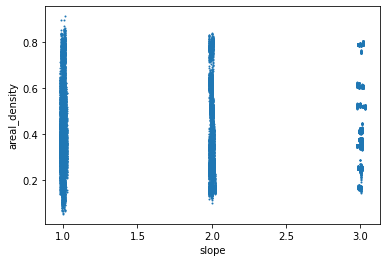

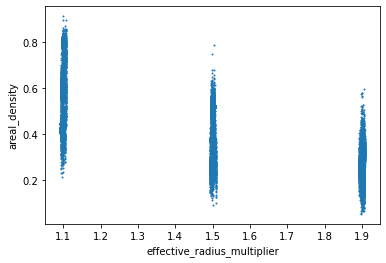

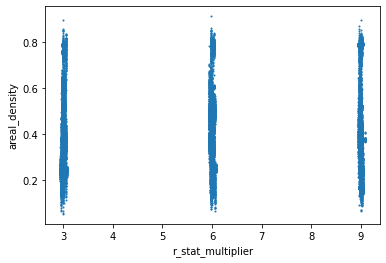

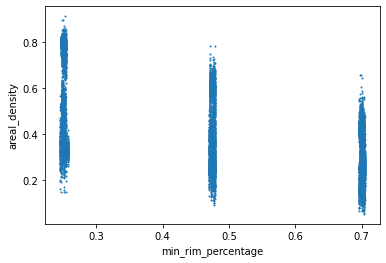

In [6]:
series = train_df[metric]

for iv in ivs:
    plt.scatter(train_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

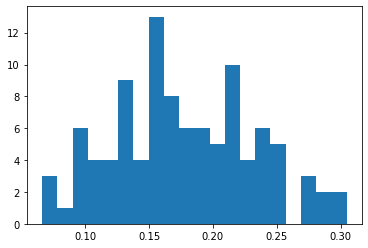

In [7]:
plt.hist(train_df[train_df.simulation_id == 26][metric], bins=20)
plt.show()

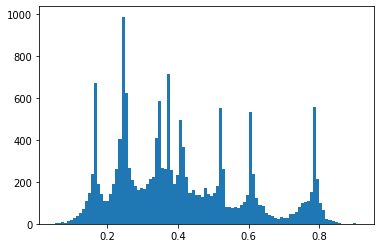

In [8]:
plt.hist(train_df[metric], bins=100)
plt.show()

### Baseline Linear Regression Model

In [9]:
alpha = 0.05

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.6497
Model:                       QuantReg   Bandwidth:                     0.01243
Method:                 Least Squares   Sparsity:                       0.1276
Date:                Mon, 29 May 2023   No. Observations:                16362
Time:                        14:01:52   Df Residuals:                    16357
                                        Df Model:                            4
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.1235      0.001   1043.099      0.000       1.121       1.126
slope                           0.0421      0.000    142.856      0.000       0.042       0.043
effective_radius_multiplier    -0.4040      0.001   -739.004   

### With Interactions

In [10]:
alpha = 0.05
exclude = {}

features = [x for x in ivs if x not in exclude]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM All Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.7506
Model:                       QuantReg   Bandwidth:                    0.008779
Method:                 Least Squares   Sparsity:                      0.07918
Date:                Mon, 29 May 2023   No. Observations:                16362
Time:                        14:01:53   Df Residuals:                    16347
                                        Df Model:                           14
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.6592      0.001   1070.177      0.000       0.658       0.660
slope                                              0.1924      0.001    134.007      0.000       0.190

#### Removing Insignificant Variables

In [11]:
alpha = 0.01

exclude = {
    "slope r_stat_multiplier", # p-value
    "r_stat_multiplier^2", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "r_stat_multiplier", # effect size
    "slope effective_radius_multiplier", # effect size
    "slope min_rim_percentage", # effect size
    "slope^2", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.6895
Model:                       QuantReg   Bandwidth:                     0.01453
Method:                 Least Squares   Sparsity:                       0.1914
Date:                Mon, 29 May 2023   No. Observations:                16362
Time:                        14:01:54   Df Residuals:                    16356
                                        Df Model:                            5
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.6349      0.000   1344.414      0.000       0.634       0.636
slope                                              0.1344      0.000    317.490      0.000       0.134

In [12]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.21531454532319316, 'slope'),
 (0.27444918187095774, 'effective_radius_multiplier^2'),
 (0.3304355503595109, 'effective_radius_multiplier min_rim_percentage'),
 (0.5859620147507545, 'min_rim_percentage'),
 (1.0, 'effective_radius_multiplier'),
 (1.0170031413124383, 'const')]

In [13]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

const                                             0.0
slope                                             0.0
effective_radius_multiplier                       0.0
min_rim_percentage                                0.0
effective_radius_multiplier^2                     0.0
effective_radius_multiplier min_rim_percentage    0.0
dtype: float64

In [14]:
alpha = 0.05

exclude = {
    "slope r_stat_multiplier", # p-value
    "r_stat_multiplier^2", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "r_stat_multiplier", # effect size
    "slope effective_radius_multiplier", # effect size
    "slope min_rim_percentage", # effect size
    "slope^2", # effect size
    "slope", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.6120
Model:                       QuantReg   Bandwidth:                    0.004987
Method:                 Least Squares   Sparsity:                       0.7014
Date:                Mon, 29 May 2023   No. Observations:                16362
Time:                        14:01:55   Df Residuals:                    16357
                                        Df Model:                            4
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.7047      0.003    238.321      0.000       0.699       0.711
effective_radius_multiplier                       -0.6398      0.011    -55.867      0.000      -0.662

In [15]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.3058723869274097, 'effective_radius_multiplier^2'),
 (0.34546925429026304, 'effective_radius_multiplier min_rim_percentage'),
 (0.577602201457293, 'min_rim_percentage'),
 (1.0, 'effective_radius_multiplier'),
 (1.1015175970191808, 'const')]

In [16]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

effective_radius_multiplier^2                      5.100763e-76
effective_radius_multiplier min_rim_percentage    5.508157e-217
const                                              0.000000e+00
effective_radius_multiplier                        0.000000e+00
min_rim_percentage                                 0.000000e+00
dtype: float64

In [17]:
alpha = 0.25

exclude = {
    "r_stat_multiplier^2", # p-value
    "effective_radius_multiplier r_stat_multiplier", # p-value
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # p-value
    "min_rim_percentage^2", # effect size
    "slope min_rim_percentage", # effect size
    "slope^2", # effect size
    "slope", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.7622
Model:                       QuantReg   Bandwidth:                    0.004061
Method:                 Least Squares   Sparsity:                       0.1124
Date:                Mon, 29 May 2023   No. Observations:                16362
Time:                        14:01:56   Df Residuals:                    16357
                                        Df Model:                            4
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.7684      0.001    763.387      0.000       0.766       0.770
effective_radius_multiplier                       -0.6532      0.004   -177.732      0.000      -0.660

In [18]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.30345385724476864, 'effective_radius_multiplier min_rim_percentage'),
 (0.3117537879243609, 'effective_radius_multiplier^2'),
 (0.5551933509948106, 'min_rim_percentage'),
 (1.0, 'effective_radius_multiplier'),
 (1.1763894319322579, 'const')]

In [19]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

const                                             0.0
effective_radius_multiplier                       0.0
min_rim_percentage                                0.0
effective_radius_multiplier^2                     0.0
effective_radius_multiplier min_rim_percentage    0.0
dtype: float64

In [20]:
alpha = 0.5

exclude = {
    "r_stat_multiplier^2", # p-value
    "effective_radius_multiplier r_stat_multiplier", # p-value
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier", # p-value
    "slope^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "slope", # effect size
    "slope min_rim_percentage", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.8203
Model:                       QuantReg   Bandwidth:                    0.003994
Method:                 Least Squares   Sparsity:                      0.04085
Date:                Mon, 29 May 2023   No. Observations:                16362
Time:                        14:02:00   Df Residuals:                    16357
                                        Df Model:                            4
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.7997      0.000   1858.882      0.000       0.799       0.801
effective_radius_multiplier                       -0.6620      0.002   -426.967      0.000      -0.665

In [21]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.3013574157046794, 'effective_radius_multiplier^2'),
 (0.3127916219051673, 'effective_radius_multiplier min_rim_percentage'),
 (0.5761093724232738, 'min_rim_percentage'),
 (1.0, 'effective_radius_multiplier'),
 (1.2081267281423944, 'const')]

In [22]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

const                                             0.0
effective_radius_multiplier                       0.0
min_rim_percentage                                0.0
effective_radius_multiplier^2                     0.0
effective_radius_multiplier min_rim_percentage    0.0
dtype: float64

### Trying with degree=3

In [201]:
alpha = 0.01

exclude = {
    "slope^2 r_stat_multiplier", # p-value
    "slope effective_radius_multiplier r_stat_multiplier", # p-value
    "effective_radius_multiplier r_stat_multiplier^2", # p-value
    "slope r_stat_multiplier min_rim_percentage", # effect size
    "r_stat_multiplier^2 min_rim_percentage", # effect size
    "slope min_rim_percentage^2", # effect size
    "slope effective_radius_multiplier^2", # effect size
    "effective_radius_multiplier^2 r_stat_multiplier", # effect size
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "effective_radius_multiplier r_stat_multiplier min_rim_percentage", # effect size
    "r_stat_multiplier min_rim_percentage^2", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope effective_radius_multiplier min_rim_percentage", # effect size
    "slope min_rim_percentage", # effect size
    "effective_radius_multiplier^2 min_rim_percentage", # effect size
    "slope^2 min_rim_percentage", # effect size
    "slope^3", # effect size
    "slope r_stat_multiplier^2", # effect size
    "slope r_stat_multiplier", # effect size
    "slope^2 effective_radius_multiplier", # effect size
    "slope effective_radius_multiplier", # effect size
    "slope^2", # effect size
    "effective_radius_multiplier min_rim_percentage^2", # effect size
    "slope", # effect size
    "min_rim_percentage^3", # effect size
    "min_rim_percentage^2", # effect size
    "effective_radius_multiplier min_rim_percentage", # effect size
    "r_stat_multiplier^3", # effect size
    "r_stat_multiplier^2", # effect size
    "r_stat_multiplier", # effect size
    "r_stat_multiplier", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.4632
Model:                       QuantReg   Bandwidth:                     0.01034
Method:                 Least Squares   Sparsity:                        2.517
Date:                Sun, 28 May 2023   No. Observations:                16362
Time:                        20:55:35   Df Residuals:                    16357
                                        Df Model:                            4
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.5318      0.006     82.718      0.000       0.519       0.544
effective_radius_multiplier       1.8258      0.535      3.410      0.001       0.776       2.875
min_rim_percentage               -0.2404      0.005    

In [199]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.03720813176193704, 'min_rim_percentage'),
 (0.082303420644099, 'const'),
 (0.28257308139182075, 'effective_radius_multiplier'),
 (0.6757899522990306, 'effective_radius_multiplier^3'),
 (1.0, 'effective_radius_multiplier^2')]

In [200]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

effective_radius_multiplier      0.000650
effective_radius_multiplier^2    0.000039
effective_radius_multiplier^3    0.000030
const                            0.000000
min_rim_percentage               0.000000
dtype: float64

### Using Recursive Feature Elimination With Interactions

In [211]:
alpha = 0.05

exclude = {}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

In [212]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_kwargs={}):
        self.model_class = model_class
        self.fit_kwargs = fit_kwargs
        
    def fit(self, X, y):
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(**self.fit_kwargs)
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    @property
    def coef_(self):
        return self.results_.params

In [217]:
def get_scorer(alpha: float, inverse_transform=lambda x: x):
    def internal_scorer(model, X, y):
        y_pred = inverse_transform(model.predict(X))
        score = ((y < y_pred).mean() - alpha)**2
        return -score
    
    return internal_scorer

In [218]:
min_features_to_select = 1 
model = SMWrapper(sm.QuantReg, fit_kwargs={"q": 0.05})
cv = KFold(5)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring=get_scorer(alpha, inverse_transform=lambda x: x),
    min_features_to_select=min_features_to_select,
    n_jobs=15
)
rfecv.fit(X_train, y_train)

/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/ma

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=SMWrapper(fit_kwargs={'q': 0.05},
                          model_class=<class 'statsmodels.regression.quantile_regression.QuantReg'>),
      n_jobs=15,
      scoring=<function get_scorer.<locals>.internal_scorer at 0x7f540db06680>)

In [219]:
model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train[rfecv.get_feature_names_out()]),
                                         y_train,
                                         [sm.add_constant(x[rfecv.get_feature_names_out()]) for x in X_tests],
                                         y_tests,
                                         "LM With RFE Features",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                         QuantReg Regression Results                          
Dep. Variable:          areal_density   Pseudo R-squared:               0.3410
Model:                       QuantReg   Bandwidth:                     0.02446
Method:                 Least Squares   Sparsity:                       0.2131
Date:                Sun, 28 May 2023   No. Observations:                16362
Time:                        21:03:38   Df Residuals:                    16351
                                        Df Model:                           10
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.3395      0.002    186.623      0.000       0.336       0.343
slope                             1.0303      0.069     15.034      0.000       0.896       1.165
effective_radius_multiplier      -0.2139      0.108    

### Plotting Prediction Intervals

In [23]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

In [24]:
# model_configs = {
#     0.01: {
#         "exclude_features": {
#             "slope r_stat_multiplier", # p-value
#             "r_stat_multiplier^2", # effect size
#             "r_stat_multiplier min_rim_percentage", # effect size
#             "effective_radius_multiplier r_stat_multiplier", # effect size
#             "min_rim_percentage^2", # effect size
#             "r_stat_multiplier", # effect size
#             "slope effective_radius_multiplier", # effect size
#             "slope min_rim_percentage", # effect size
#             "slope^2", # effect size
#         }
#     },
#     0.05: {
#         "exclude_features": {
#             "slope r_stat_multiplier", # p-value
#             "r_stat_multiplier^2", # effect size
#             "r_stat_multiplier min_rim_percentage", # effect size
#             "effective_radius_multiplier r_stat_multiplier", # effect size
#             "min_rim_percentage^2", # effect size
#             "r_stat_multiplier", # effect size
#             "slope effective_radius_multiplier", # effect size
#             "slope min_rim_percentage", # effect size
#             "slope^2", # effect size
#             "slope", # effect size
#         }
#     },
#     0.25: {
#         "exclude_features": {
#             "slope r_stat_multiplier", # p-value
#             "r_stat_multiplier^2", # effect size
#             "r_stat_multiplier min_rim_percentage", # effect size
#             "effective_radius_multiplier r_stat_multiplier", # effect size
#             "min_rim_percentage^2", # effect size
#             "r_stat_multiplier", # effect size
#             "slope effective_radius_multiplier", # effect size
#             "slope min_rim_percentage", # effect size
#             "slope^2", # effect size
#             "slope", # effect size
#         }
#     },  
#     0.5: {
#         "exclude_features": {
#             "slope r_stat_multiplier", # p-value
#             "r_stat_multiplier^2", # effect size
#             "r_stat_multiplier min_rim_percentage", # effect size
#             "effective_radius_multiplier r_stat_multiplier", # effect size
#             "min_rim_percentage^2", # effect size
#             "r_stat_multiplier", # effect size
#             "slope effective_radius_multiplier", # effect size
#             "slope min_rim_percentage", # effect size
#             "slope^2", # effect size
#             "slope", # effect size
#         }
#     },  
# }

model_configs = {
    0.01: {
        "exclude_features": {
            "slope r_stat_multiplier", # p-value
            "r_stat_multiplier^2", # effect size
            "r_stat_multiplier min_rim_percentage", # effect size
            "effective_radius_multiplier r_stat_multiplier", # effect size
            "min_rim_percentage^2", # effect size
            "r_stat_multiplier", # effect size
            "slope effective_radius_multiplier", # effect size
            "slope min_rim_percentage", # effect size
            "slope^2", # effect size
            "slope", # effect size
        }
    },
    0.05: {
        "exclude_features": {
            "slope r_stat_multiplier", # p-value
            "r_stat_multiplier^2", # effect size
            "r_stat_multiplier min_rim_percentage", # effect size
            "effective_radius_multiplier r_stat_multiplier", # effect size
            "min_rim_percentage^2", # effect size
            "r_stat_multiplier", # effect size
            "slope effective_radius_multiplier", # effect size
            "slope min_rim_percentage", # effect size
            "slope^2", # effect size
            "slope", # effect size
        }
    },
    0.25: {
        "exclude_features": {
            "slope r_stat_multiplier", # p-value
            "r_stat_multiplier^2", # effect size
            "r_stat_multiplier min_rim_percentage", # effect size
            "effective_radius_multiplier r_stat_multiplier", # effect size
            "min_rim_percentage^2", # effect size
            "r_stat_multiplier", # effect size
            "slope effective_radius_multiplier", # effect size
            "slope min_rim_percentage", # effect size
            "slope^2", # effect size
            "slope", # effect size
        }
    },  
    0.5: {
        "exclude_features": {
            "slope r_stat_multiplier", # p-value
            "r_stat_multiplier^2", # effect size
            "r_stat_multiplier min_rim_percentage", # effect size
            "effective_radius_multiplier r_stat_multiplier", # effect size
            "min_rim_percentage^2", # effect size
            "r_stat_multiplier", # effect size
            "slope effective_radius_multiplier", # effect size
            "slope min_rim_percentage", # effect size
            "slope^2", # effect size
            "slope", # effect size
        }
    },  
}

model_configs = [
    {
        "alpha": alpha,
        "model": sm.QuantReg(y_train, sm.add_constant(X_train[[x for x in X_train.columns if x not in config["exclude_features"]]])).fit(alpha),
        "exclude_features": config["exclude_features"]
    }
    for (alpha, config) in model_configs.items()
]

In [25]:
# Load up a subset of the test DFs
np.random.seed(123)

sample_cadence = 100
in_ccd_paths = list(Path(base_path).glob("simulation_*.parquet"))
outside_ccd_paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))

In [27]:
def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path, columns=ivs + dvs + ["simulation_id", "n_craters_added_in_study_region"])
    return df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()


def score_models(model_configs: list,
                 df: pd.DataFrame,
                 metric: str,
                 inverse_transform,
                 add_constant: bool) -> pd.DataFrame:
    X = df[ivs]
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
    X = poly_transform.transform(X)
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

    pred_df = df.reset_index(drop=True).copy()
    for feature_name in poly_transform.get_feature_names_out():
        pred_df[feature_name] = X[feature_name]
    
    y = df[metric]
    
    if add_constant:
        X = sm.add_constant(X, has_constant="add")
    pred_df["actual"] = list(y)
    pred_df["n_craters"] = list(df.index)
    
    for model_config in model_configs:
        alpha = model_config["alpha"]
        model = model_config["model"]
        exclude_features = model_config["exclude_features"]
        
        predictions = inverse_transform(model.predict(X[[x for x in X.columns if x not in exclude_features]]))
        pred_df[f"alpha_{alpha:.2f}"] = predictions
        
    return pred_df


def score_models_from_parquet_file(model_configs: list,
                                   parquet_path: Path,
                                   sample_cadence: int,
                                   metric: str,
                                   inverse_transform,
                                   add_constant: bool) -> pd.DataFrame:
    df = read_simulation_parquet(parquet_path, sample_cadence)
    return score_models(model_configs, df, metric, inverse_transform, add_constant)


def score_models_on_multiple_files(model_configs: list,
                                   parquet_paths: list[Path],
                                   sample_cadence: int,
                                   metric: str,
                                   inverse_transform,
                                   add_constant: bool) -> pd.DataFrame:
    results = []
    for path in parquet_paths:
        scored = score_models_from_parquet_file(models,
                                               parquet_path,
                                               sample_cadence,
                                               metric,
                                               inverse_transform,
                                               add_constant)
        results.append(scored)
    
    return pd.concat(results, axis=0)

import time

def plot_holdout_sim_ci(model_configs: list,
                        parquet_path: Path,
                        sample_cadence: int,
                        metric: str,
                        inverse_transform,
                        add_constant):
    pred_df = score_models_from_parquet_file(model_configs, parquet_path, sample_cadence, metric, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")

    ns_max = 100000
    plt.plot(pred_df.n_craters_added_in_study_region.iloc[:ns_max],
             pred_df[metric].iloc[:ns_max])
    plt.xlabel("$N_G$")
    plt.ylabel("$A_d$")
    plt.show()
    time.sleep(1)
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    for model_config in model_configs:
        alpha = model_config['alpha']
        fig.add_scatter(x=pred_df["n_craters"],
                        y=pred_df[f"alpha_{alpha:.2f}"],
                        mode="lines",
                        name=f"Pred {int(alpha*100)} Percentile")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()
    time.sleep(1)
    
    
def report_models(model_configs: list,
                  df: pd.DataFrame,
                  metric: str,
                  inverse_transform,
                  add_constant: bool):
    pred_df = score_models(model_configs, df, metric, inverse_transform, add_constant)
    
    # Report for only the last third
    pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
    
    for model_config in model_configs:
        alpha = model_config["alpha"]
        percent_below = (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        

def report_models_for_parquets(model_configs: list,
                               parquet_paths: list[Path],
                               sample_cadence: int,
                               metric: str,
                               inverse_transform,
                               add_constant: bool):
    n_below = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    for path in parquet_paths:
        pred_df = score_models_from_parquet_file(model_configs, path, sample_cadence, metric, inverse_transform, add_constant)
        
        # Report for only the last third
        pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
        
        for model_config in model_configs:
            alpha = model_config["alpha"]
            n_below[alpha] += (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).sum()
            n[alpha] += pred_df.shape[0]
    
    for model_config in model_configs:
        alpha = model_config["alpha"]
        percent_below = n_below[alpha] / n[alpha] * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")

10
Simulation parameters: slope                          0.986364
effective_radius_multiplier    0.991116
r_stat_multiplier              0.987785
min_rim_percentage             0.009747
Name: 0, dtype: float64


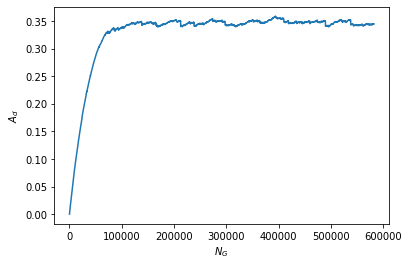

11
Simulation parameters: slope                          0.497845
effective_radius_multiplier    0.991116
r_stat_multiplier              0.498734
min_rim_percentage             0.990895
Name: 0, dtype: float64


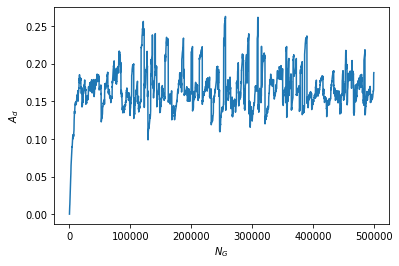

12
Simulation parameters: slope                          0.986364
effective_radius_multiplier    0.500548
r_stat_multiplier              0.009682
min_rim_percentage             0.990895
Name: 0, dtype: float64


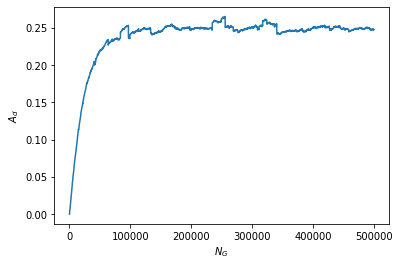

13
Simulation parameters: slope                          0.497845
effective_radius_multiplier    0.500548
r_stat_multiplier              0.987785
min_rim_percentage             0.009747
Name: 0, dtype: float64


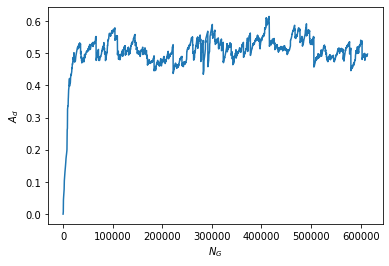

14
Simulation parameters: slope                          0.009327
effective_radius_multiplier    0.009981
r_stat_multiplier              0.009682
min_rim_percentage             0.009747
Name: 0, dtype: float64


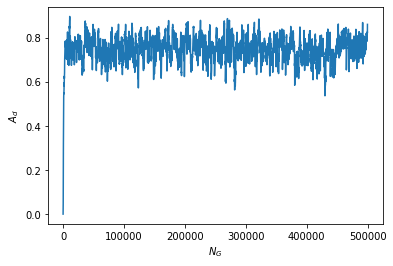

In [28]:
# Visualize CIs for a few in-CCD simulations
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model_configs, in_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

10
Simulation parameters: slope                          0.737441
effective_radius_multiplier    0.749535
r_stat_multiplier              0.738751
min_rim_percentage             0.828389
Name: 0, dtype: float64


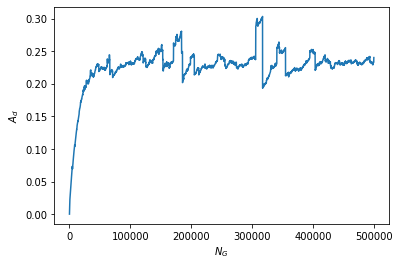

11
Simulation parameters: slope                          0.745171
effective_radius_multiplier    0.747812
r_stat_multiplier              0.252524
min_rim_percentage             0.286815
Name: 0, dtype: float64


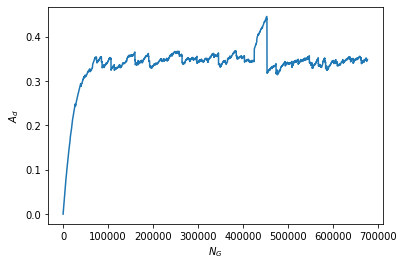

12
Simulation parameters: slope                          0.255893
effective_radius_multiplier    0.743409
r_stat_multiplier              0.741341
min_rim_percentage             0.827450
Name: 0, dtype: float64


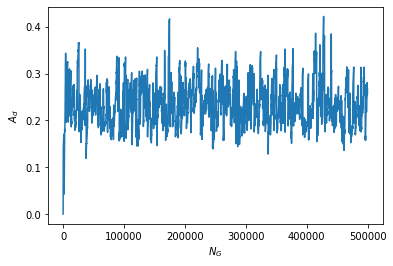

13
Simulation parameters: slope                          0.253586
effective_radius_multiplier    0.745832
r_stat_multiplier              0.254208
min_rim_percentage             0.282288
Name: 0, dtype: float64


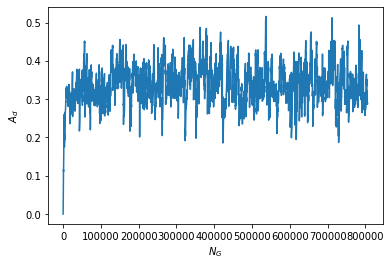

14
Simulation parameters: slope                          0.742547
effective_radius_multiplier    0.257794
r_stat_multiplier              0.257088
min_rim_percentage             0.826457
Name: 0, dtype: float64


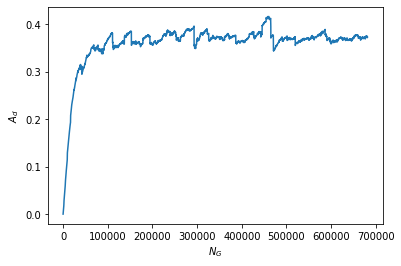

In [29]:
# Visualize CIs for a few simulations outside the CCD
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model_configs, outside_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

In [30]:
# Report for train data
report_models(model_configs, train_df, metric, lambda x: x, True)

Alpha = 0.01, % below: 1.30
Alpha = 0.05, % below: 6.34
Alpha = 0.25, % below: 28.57
Alpha = 0.50, % below: 54.79


In [31]:
# Report for in-CCD test sims
report_models_for_parquets(model_configs, in_ccd_paths, sample_cadence, metric, lambda x: x, True)

Alpha = 0.01, % below: 1.12
Alpha = 0.05, % below: 5.55
Alpha = 0.25, % below: 25.99
Alpha = 0.50, % below: 52.15


In [32]:
# Report for outside-CCD test sims
report_models_for_parquets(model_configs, outside_ccd_paths, sample_cadence, metric, lambda x: x, True)

Alpha = 0.01, % below: 0.27
Alpha = 0.05, % below: 3.50
Alpha = 0.25, % below: 26.36
Alpha = 0.50, % below: 58.65
